<a href="https://colab.research.google.com/github/mdjamina/M1_TALA410A_NLP/blob/main/Project_NLP_S2/Word2Vec_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/armandstrickernlp/NLP_Inalco/main/Semester2/Project_sem2/shakespeare.txt

--2022-05-24 05:39:58--  https://raw.githubusercontent.com/armandstrickernlp/NLP_Inalco/main/Semester2/Project_sem2/shakespeare.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 306996 (300K) [text/plain]
Saving to: ‘shakespeare.txt’

shakespeare.txt     100%[===================>] 299.80K  --.-KB/s    in 0.03s   

2022-05-24 05:39:58 (8.96 MB/s) - ‘shakespeare.txt’ saved [306996/306996]



# Word2Vec : Creating Word Embeddings with Pytorch

References : 
* https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa
* https://www.coursera.org/learn/probabilistic-models-in-nlp/home/week/4

## Why do we need word embeddings ?

Before thinking about word embeddings, when doing NLP, we are interested in being able to transform sentences or words into numeric representations, to then feed them to our algorithms and perform predictions.  Some simple methods of doing so include using term frequencies or n-grams among other things (counting the number of times a word appears in positive tweets vs. negative tweets for example)...  While these can work quite well in some cases, sentences are essentially represented as "Bags of Words", meaning a lot of information is lost : sentence structure, semantics, what the usual context for a word is (the word *cat* for example may be frequently accompanied by *a* or *the* on the left since it's a noun).  

So how can we find more expressive numeric representations ?  This motivated NLP researchers to create more sophisticated word representations, known as *word embeddings*.  These are *dense* vectors (vs. *sparse* vectors, vectors with many dimensions where most of the values are 0s) and are now fundamental to any machine learning algorithm in NLP.

## What principle do these word embeddings rely on ?

Creating word embeddings relies on the idea that "You shall know a word by the company it keeps" (Firth, 1957). In [distributional semantics](https://en.wikipedia.org/wiki/Distributional_semantics#Distributional_Hypothesis), the distributional hypothesis tells us that words which occur and are used in the same context are semantically similar to one another.  The word vectors (embeddings) created take into account this contextual information, and the resulting vectors for words that have *similar contexts* end up in the same area of the vector space :

<img src='https://github.com/armandstrickernlp/NLP_Inalco/blob/main/Semester2/Project_sem2/vector_space_example.jpg?raw=1'/>

## The Word2Vec Model

This model was created by Google in 2013 and is a predictive deep learning based model :  given neighboring words, the neural network has to *predict* the word to be found at the center of the context given (this is only one of the possible architectures).


Essentially, this model can leverage raw text (no annotations needed), create a vocabulary of possible words and generate dense word embeddings for each word. We can even specify the size of the word embedding vectors, which makes the dimensionality of the vectors much lower than the high-dimensional sparse vectors built using traditional Bag of Words models.

The model architecture we will be looking at is called the **Continuous Bag of Words Model**.

## The Continuous Bag of Words Model (CBOW) 

To create word embeddings, you need a corpus and a learning algorithm. The *by-product* of this task would be a set of word embeddings. In the case of the continuous bag-of-words model, the objective of the task is to predict a missing word based on the surrounding words.

<div style='text-align:center;'><img src='https://github.com/armandstrickernlp/NLP_Inalco/blob/main/Semester2/Project_sem2/Embedding_method.png?raw=1'/></div>

The CBOW model architecture tries to predict the current target word (the center word) based on context words (the surrounding words). Let's take a simple example :
> **“the quick brown fox jumps over the lazy dog”**.

The sentence will be transformed into a series of examples for the model to train on : each example will consist of a (context_window, target_word) tuple.  Considering a context window of size $C=2$ (2 words to the left, 2 to the right, so 4 total) we would obtain :
> Ex. 1 : (*[the, quick, fox, jumps]*, brown)  
> Ex. 2 : (*[quick, brown, jumps, over]*, fox)  
> Etc ...

The neural net's task will be to predict the target word based on the context window words.

This means we can model this problem as a classification task such that we take in the context words as our input (X) and try to predict the target word (Y) out of all the possible words in the vocabulary.  This is essentialy a *multiclass* classification task (only 1 of the possible classes is correct), where a class is equivalent to a word in the vocabulary.  Here is an overview of the process : 

<div style='text-align:center;'><img src="https://github.com/armandstrickernlp/NLP_Inalco/blob/main/Semester2/Project_sem2/CBOW_overview.png?raw=1"/></div>

## Implementing the CBOW model

Using text from Shakespeare's plays, you will implement the CBOW model from scratch, using pytorch to simplify the creation of the network architecture and training loop. The implementation will be divided into 4 parts: 
* **Building the corpus Vocab**
* **Create the (context_window, target_word) examples**
* **Build the neural network architecture**
* **Train the model**
* **Visualize the word embeddings**

### 1. Building the corpus Vocab

In the next cell, the text has been loaded and split into tokens for you :

In [2]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import re  


with open('shakespeare.txt') as f:
    text = f.read()   
text = re.sub(r'[,!?;-]', '.',text)                                 #  Punktuations are replaced by .
text = nltk.word_tokenize(text)                                     #  Tokenize string to words
text = [ ch.lower() for ch in text if ch.isalpha() or ch == '.']    #  Lower case and drop non-alphabetical tokens
print("Number of tokens:", len(text), '\n First 15 tokens : ', text[:15])  #  print data sample

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Number of tokens: 60933 
 First 15 tokens :  ['o', 'for', 'a', 'muse', 'of', 'fire', '.', 'that', 'would', 'ascend', 'the', 'brightest', 'heaven', 'of', 'invention']


Next you must :
* Get the vocabulary and vocabulary size (the set() function can be useful...)
* Create 2 dictionaries :
    * word2idx => keys are words in vocab, values are a unique number you must attribute to each word
    * idx2word => keys are a unique number, values are the corresponding word  
    These dictionaries will allow you to map words in the vocab to unique numbers.  This is necessary as you will be feeding these numbers to the model, not the words directly.
* Create the (context, target) example pairs and store them in a list called data.

In [3]:
# get the vocab and vocab length 
vocab = [v for v in set(text) ]
vocab_size = len(vocab)
print(f"Vocab size = {vocab_size} (should be equal to 5775)")

Vocab size = 5772 (should be equal to 5775)


In [4]:
# create the word2idx and idx2word dictionaries:
word2idx = {k:v for (v,k) in enumerate(vocab)}
idx2word = {k:v for (k,v) in enumerate(vocab)}
# example of word to index mapping
print("Index of the word 'king' :  ",word2idx['king'] )
print("Word which has index 250:  ",idx2word[5367] )

Index of the word 'king' :   1223
Word which has index 250:   celerity


In [5]:
# Going through the text, create a list of data examples, where each example consists of a (context, target) tuple.
# The context can be represented as a list of the context words (2 before and 2 after)
# You may start at word idx number 2 and end on the second to last word.

data = [([a,b,d,e],c) for (a,b,c,d,e) in zip(*[text[i:] for i in range(5)])]

# loop to make training examples
...


# check if it works for the first example   
print(f'first 5 words : {text[:5]}')
print(f'example n°1 = {data[0]}')
print(f'context = {data[0][0]}')
print(f'target = {data[0][1]}')

print(f'Number of examples : {len(data)}')

first 5 words : ['o', 'for', 'a', 'muse', 'of']
example n°1 = (['o', 'for', 'muse', 'of'], 'a')
context = ['o', 'for', 'muse', 'of']
target = a
Number of examples : 60929


Expected output is :
first 5 words : ['o', 'for', 'a', 'muse', 'of']  
example n°1 = (['o', 'for', 'muse', 'of'], 'a')  
context = ['o', 'for', 'muse', 'of']  
target = a  
Number of examples : 60972

### 2. Building the neural net architecture with pytorch

In [6]:
# https://pytorch.org/get-started/locally/ to see how to install pytorch if you
# are working on your own computer
# however using googlecolab might be easier
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### 2.1 Batching the data examples

In order to accelerate the training process, we can **batch** training examples together.  This means that instead of feeding the model 1 example at a time, we feed it 16 or 32 or 64 or 128 in one go.  Pytorch's `Dataloader`class takes care of this for you.  It takes as arguments a pytorch `Dataset`(`TensorDataset` in this case) and a `batch_size`.  
To be instantiated, the `TensorDataset` class needs a pytorch tensor (`torch.tensor(listOfValues)`) of inputs and targets as arguments.  In this case you will need to create a tensor of contexts, where 1 context has to be a list of indices corresponding to the context words, and a tensor of targets, where the target words are also respresented by their idx.  Use the word2idx dictionary and data list you created previously.

In [7]:
from torch.utils.data import TensorDataset, DataLoader

contexts = torch.Tensor([ list(map(lambda x : word2idx[x], ctx)) for ctx,_ in data]).to(torch.int64)
targets = torch.Tensor([ word2idx[trg] for _,trg in data]).to(torch.int64)

assert len(contexts) == len(targets)

dataset = TensorDataset(contexts, targets)
dataloader = DataLoader(dataset, batch_size=128)

In [8]:
print(contexts.shape)
print(contexts[:2])
print(targets[:2])

torch.Size([60929, 4])
tensor([[3056, 2544, 1329, 3201],
        [2544, 4005, 3201,  693]])
tensor([4005, 1329])


Expected output should look similar to this (the indexes may not be the same):  

torch.Size([60972, 4])  
tensor([[ 441, 1818, 3263, 3379],
        [1818, 5013, 3379, 1883]])  
tensor([5013, 3263])

#### 2.2 The Model architecture

Here is an overview of the model's architecture and how a single example flows through the layers :  

<div style='text-align:center;'/><img src='https://github.com/armandstrickernlp/NLP_Inalco/blob/main/Semester2/Project_sem2/Model_architecture.png?raw=1'>

Take a look at the XOR notebook to see how a model class is created in pytorch (how it subclasses nn.Module and the init function especially).

You may add the `vocab_size` and number of embedding dimensions (`embedding_dim`) you want your embeddings to have (50 is a good choice) to the init parameters, so as to pass them in when you instantiate the model. 

Pytorch allows you to implement a special layer, called an embedding layer (`nn.Embedding`), which precisely serves the purpose of allowing you to train embeddings when training a model. Look at the the documentation to see what this layer takes as inputs : https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html

Then, add an output layer.  Be aware of the input and output sizes of the layer...  Take a look at the notebook on the XOR problem to see how to create a linear layer in pytorch.

The `forward` function is the one that deals with the flow of data through the model.  In this case, it takes as input a *batch* of context vectors.
This batch must first go through the embedding layer which returns 4 vectors (1 for each word) of equal dimension for each example in the batch.  
If you have chosen a batch size of 128 and an embedding dimension of 50, then the output shape of the `nn.Embedding` layer will be:  (128, 4, 50):  128 matrices (one per example in the batch) of 4 by 50 (one 50 dimensional vector per context word).


For each example in the batch, you will average these 4 vectors in order to obtain a single vector.  This means you must specifiy that the mean calculated has to be along dimension 1 (the one equal to 4).  This is why the model is called Continuous Bag of Words: we don’t really consider the order of the context words when averaging them...  So that information is lost.

Then, all that is left is to pass the batch of averaged vectors to the output layer !

No need to use the softmax function as a final activation function here, as this will be done automatically by the loss function in the training loop (cf. section 2.4).

In [9]:
# Create the Neural Net

class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim = 50):
      super(CBOW, self).__init__()
      self.embeddings = nn.Embedding(vocab_size, embedding_dim)
      self.linear = nn.Linear(embedding_dim, vocab_size)
      self.window_size = 2
        

    def forward(self, batch):
        # get the embeddings from the Embedding layer and average them along dim=1.
        # use .shape to see what shape the batch has before and after going through 
        # each layer if you need to
        # pass the batch through the output layer to get the logits
        # the output should be a matrix with dimensions batch_size x vocab_size
        embeds = torch.mean(self.embeddings(batch), dim=1)
        
        out = self.linear(embeds) 

        log_probs = F.log_softmax(out, dim=1) # softmax compute log probability

        return log_probs
       

        

In [10]:
# set random seed 
torch.manual_seed(42)

#instantiate the model
model = CBOW(vocab_size, 
             embedding_dim=50)
print(model)

CBOW(
  (embeddings): Embedding(5772, 50)
  (linear): Linear(in_features=50, out_features=5772, bias=True)
)


Your model should look something like this :

CBOW(  
    (embeddings): Embedding(5775, 50)   
    (output): Linear(in_features=50, out_features=5775, bias=True)  
)

#### 2.3 Visualizing word vectors before training

To see if the model has had any effect on the word vectors (which are randomly initialized when you instantiate the model), it can be useful to compare the vectors for certain words before vs. after training.  In order to plot and visualize the vectors in 2D, we must however use an algorithm called *Principal Component Analysis (PCA)* to reduce the vectors' dimensions down to 2.  This can be easily done using `sklearn`.  

In the cell below, you have a list of words which you can modifiy as you wish.

[ 6.367725  -1.0531487]


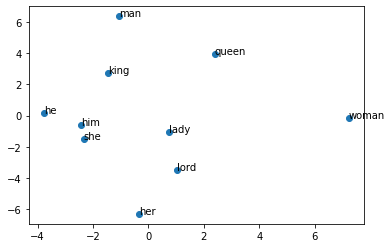

In [11]:
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot

# list of words to study
words = ['man', 'woman', 'lord', 'lady', 'king', 'queen', 'her', 'him', 'he', 'she']

# the embeddings for the words, randomly initialized by the model
embeddings = np.array([model.embeddings(torch.tensor(word2idx[word],dtype=torch.long)).detach().numpy() 
                       for word in words]).squeeze()

# perform PCA (reduce to 2 dimensions)
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

# get the 2D embedding reduction for the first word in the list, to track after training
print(reduced[0])

# plotting the 2D vectors
pyplot.scatter(reduced[:,1], reduced[:, 0])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(reduced[i, 1], reduced[i, 0]))
pyplot.show()

#### **Question** : 

How would you expect the vectors to move ?  Which word vectors should end up closer ?

#### 2.4 Training Loop

Start by selecting the appropriate loss function and optimizer.  You may use `nn.CrossEntropyLoss()` as a loss function and `torch.optim.SGD`for the optimizer.  This optimizer is an implementation of the Gradient Descent algorithm and takes as arguments `model.parameters()`, the model's parameters, and `lr` the learning rate, which can be set to 0.03 when using batches of 128 (you may tru different values).  

Next you can run the model for 150-200 epochs.  This should be able to run on your computer, but if not just copy paste all of the cells into a colab notebook.  The fact that we divided the training data into batches means each epoch should take approx. 10 secs instead of several minutes.  

In [18]:
import time
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03)

#TRAINING
# a few seconds per epoch
# you can track the time passed per epoch by decommenting the time1 line and the print(time.time...) at the end.
for epoch in range(150):
    #time1 = time.time()
    
    # initiliaze the total_loss for each epoch to 0
    total_loss = 0

    # the dataloader is a generator object, it produces a batch of contexts and targets if you iterate over it.
    for context, target in dataloader:
        
        # get the logits
        logits = model(context)
        
        # calculate the loss by passing the logits and targets to the loss_function
        loss = loss_function(logits,target)
        
        # add the loss value to the total_loss (use loss.item() to get only the value)
        total_loss += loss.item()

        #print(total_loss)

        
        # optimize the network using the three steps seen in the XOR notebook
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # track the loss by printing it every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1} : {total_loss}')
    
    #print(time.time()-time1)

Epoch 10 : 3183.870708465576
Epoch 20 : 2994.1759328842163
Epoch 30 : 2900.924533724785
Epoch 40 : 2841.183914422989
Epoch 50 : 2798.5702838897705
Epoch 60 : 2765.593357205391
Epoch 70 : 2738.663918375969
Epoch 80 : 2715.8324650526047
Epoch 90 : 2695.9211064577103
Epoch 100 : 2678.1737600564957
Epoch 110 : 2662.082222700119
Epoch 120 : 2647.2916755080223
Epoch 130 : 2633.546841084957
Epoch 140 : 2620.659690439701
Epoch 150 : 2608.4890607595444


#### 2.5 Visualizing word vectors before training

Using the same list of words as before, the next cell plots the new word vectors.  What has changed ? Do the results seem to verify your hypotheses ?  
How do you think the results could be improved ?

You can try changing the hyperparameters to see if they have any impact.  These include :
* batch size
* number of embedding dimensions
* learning rate
* number of epochs

[ 6.438661  -0.8225599]


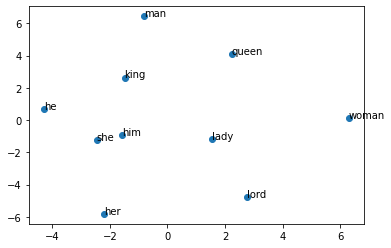

In [19]:
embeddings = np.array([model.embeddings(torch.tensor(word2idx[word],dtype=torch.long)).detach().numpy() 
                       for word in words]).squeeze()

reduced = pca.fit_transform(embeddings)
print(reduced[0])

pyplot.scatter(reduced[:,1], reduced[:, 0])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(reduced[i, 1], reduced[i, 0]))
pyplot.show()